In [267]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

In [268]:
# Move to project root
from pathlib import Path
import os

if not Path("./src/models").is_dir():
    for parent_path in Path.cwd().parents:
        if (parent_path / "src/models").is_dir():
            os.chdir(parent_path)
            break
    else:
        raise FileNotFoundError("Can't find project root")

assert Path("./src/models").is_dir()

In [ ]:
fake_data = pl.read_parquet("./.data/long_k_mnist.pq").with_columns(
    pl.col("standard-3").alias("standard-1"),
    pl.col("standard-3").alias("standard-2"),
    pl.col("standard-5").alias("standard-4"),
    pl.col("iso-3-ss").alias("iso-2-ss"),
    pl.col("aniso-3-ss-iso-spin").alias("aniso-2-ss-iso-spin"),
    pl.col("aniso-3-skewed-spin").alias("aniso-2-skewed-spin"),
)


def _sort_key(s: str):
    name, size, *rest = s.split("-")
    order = {"standard": 0, "iso": 1, "aniso": 2}[name]
    return order, rest, int(size)


fake_data = fake_data.select(sorted(fake_data.columns, key=_sort_key))
fake_data

In [ ]:
plt.rc()

In [235]:
def preprocess_data(
    data: pl.DataFrame, metric: str = "acc", low: float = 0.05, high: float = 0.95
):
    return (
        data.select(
            pl.all()
            .implode()
            .list.eval(
                pl.struct(
                    mean=pl.element().struct.field(metric).mean(),
                    high=pl.element().struct.field(metric).quantile(high),
                    low=pl.element().struct.field(metric).quantile(low),
                )
            )
            .list.get(0)
        )
        .transpose(include_header=True, column_names=["metric"], header_name="kind")
        .lazy()
        .unnest("metric")
        .with_columns(
            pl.col("kind").str.split_exact("-", 2),
            grouped=pl.col("kind").str.contains("grouped"),
            closing=pl.col("kind").str.contains("closing"),
        )
        .select(
            pl.col("kind")
            .struct[0]
            .add(
                pl.when(pl.col("kind").struct[2].is_not_null())
                .then(pl.lit("-").add(pl.col("kind").struct[2]))
                .otherwise(pl.lit(""))
            )
            .alias("kind"),
            pl.col("kind").struct[1].cast(int).alias("size"),
            "grouped",
            "closing",
            "low",
            "mean",
            "high",
        )
        .collect()
    )


fake_pre = preprocess_data(fake_data, metric="acc")
fake_pre

kind,size,grouped,closing,low,mean,high
str,i64,bool,bool,f64,f64,f64
"""standard""",1,false,false,0.949327,0.955834,0.963108
"""standard""",2,false,false,0.949327,0.955834,0.963108
"""standard""",3,false,false,0.949327,0.955834,0.963108
"""standard""",4,false,false,0.926541,0.944839,0.958008
"""standard""",5,false,false,0.926541,0.944839,0.958008
…,…,…,…,…,…,…
"""aniso-ss""",2,false,false,0.951714,0.958236,0.963867
"""aniso-ss""",3,false,false,0.951714,0.958236,0.963867
"""aniso-ss""",5,false,false,0.953016,0.959644,0.965061


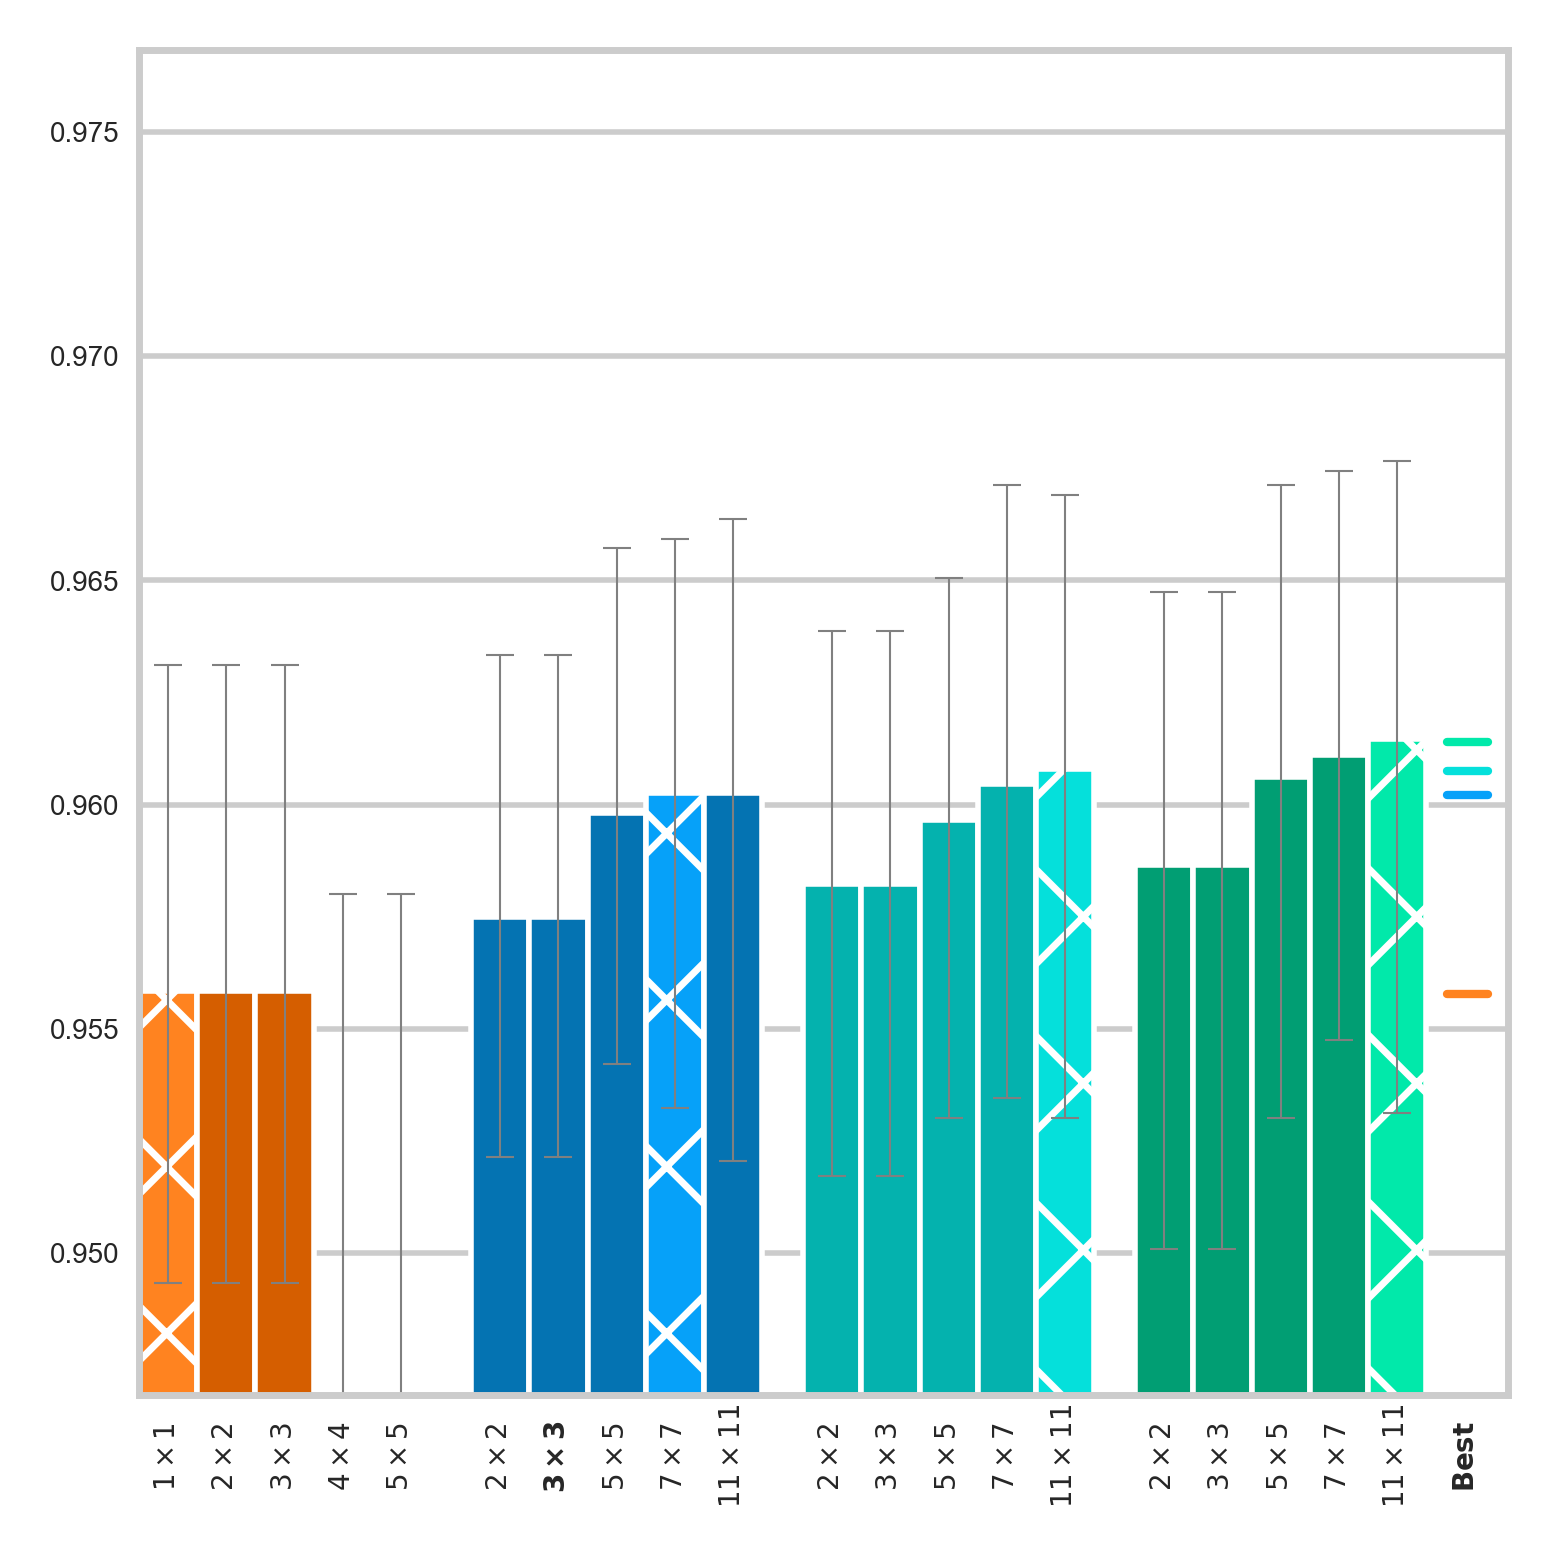

In [263]:
def plot_group_kernel_size(
    ax: plt.Axes,
    tick_positions: list[float],
    tick_labels: list[str],
    group: pl.DataFrame,
    color: str,
    begin: float,
    width: float,
    highlight: str = None,
    higher_is_better: bool = True,
):
    best = (
        group.with_row_index()
        .top_k(1, by="mean", reverse=not higher_is_better)
        .item(0, column="index")
    )
    x = begin
    for i, (_kind, size, _grp, _cls, low, mean, high) in enumerate(group.iter_rows()):
        ax.bar(
            x,
            mean,
            width,
            align="edge",
            color=highlight if highlight and i == best else color,
            hatch="x" if highlight and i == best else "",
        )
        ax.errorbar(
            x + width / 2,
            mean,
            ((mean - low,), (high - mean,)),
            color="grey",
            capsize=2,
            linewidth=0.3,
            capthick=0.3,
        )
        tick_positions.append(x + width / 2)
        if size == best:
            label = rf"$\mathbf{{{size}\times{size}}}$"
        else:
            label = rf"${size}\times{size}$"
        tick_labels.append(label)
        x += width


def plot_results(
    group_plotter,
    data: pl.DataFrame,
    baseline: tuple[str, int] = ("standard", 1),
    baseline_height: float = 0.3,
    total_height: float = 3 / 100,
    figsize: tuple[float, float] = (3, 3),
    group_gap: float = 0.03,
    higher_is_better: bool = True,
    save_path: str = None,
    x_tick_pad=4.0,
):
    sns.set_theme("paper", "whitegrid")
    fig, ax = plt.subplots(layout="compressed", figsize=figsize, dpi=500)
    bot = (
        data.filter(
            pl.col("kind").eq(baseline[0]) & pl.col("size").eq(baseline[1])
        ).item(0, "mean")
    ) - (baseline_height * total_height)
    ax.set_ylim(bot, bot + total_height)
    ax.set_xlim(0, 1)
    n_groups = data.n_unique("kind")
    total_bar_space = 1.0 - group_gap * (n_groups + 1)
    per_bar_space = total_bar_space / len(data)
    best_stripes_start = 1.0 - group_gap * 1.5
    colors = {
        "standard": ("#D55E00", "#FF8320"),
        "iso-ss": ("#0473B2", "#06A1F9"),
        "aniso-ss": ("#04B2AE", "#05E0DB"),
        "aniso-skewed": ("#019E73", "#01E9AA"),
    }

    x = 0
    tick_positions, tick_labels = [], []
    for name, (color, highlight) in colors.items():
        group = data.filter(pl.col("kind").eq(name))
        if len(group) == 0:
            continue

        group_plotter(
            ax,
            tick_positions,
            tick_labels,
            group,
            color=color,
            begin=x,
            width=per_bar_space,
            highlight=highlight,
            higher_is_better=higher_is_better,
        )
        high = group.top_k(1, by="mean", reverse=not higher_is_better).item(
            0, column="mean"
        )
        ax.plot(
            (best_stripes_start, best_stripes_start + group_gap),
            # Matplotlib draws the lines *slightly* off-centre...
            (high - 0.00006, high - 0.00006),
            color=highlight,
            # linestyle="dashed",
        )
        x += group_gap + per_bar_space * len(group)

    tick_positions.append(best_stripes_start + group_gap / 2)
    tick_labels.append(r"$\mathbf{Best}$")
    ax.set_xticks(tick_positions, tick_labels, rotation=90, va="center")
    ax.tick_params(labelsize=4)
    for tick in ax.get_xaxis().get_major_ticks():
        tick.set_pad(x_tick_pad)
    for tick in ax.get_yaxis().get_major_ticks():
        tick.set_pad(-2.0)
    ax.grid(False, axis="x")

    if save_path is not None:
        fig.savefig(save_path)


plot_results(
    plot_group_kernel_size, fake_pre, save_path="./report/figures/results_fake.png"
)
plt.show()

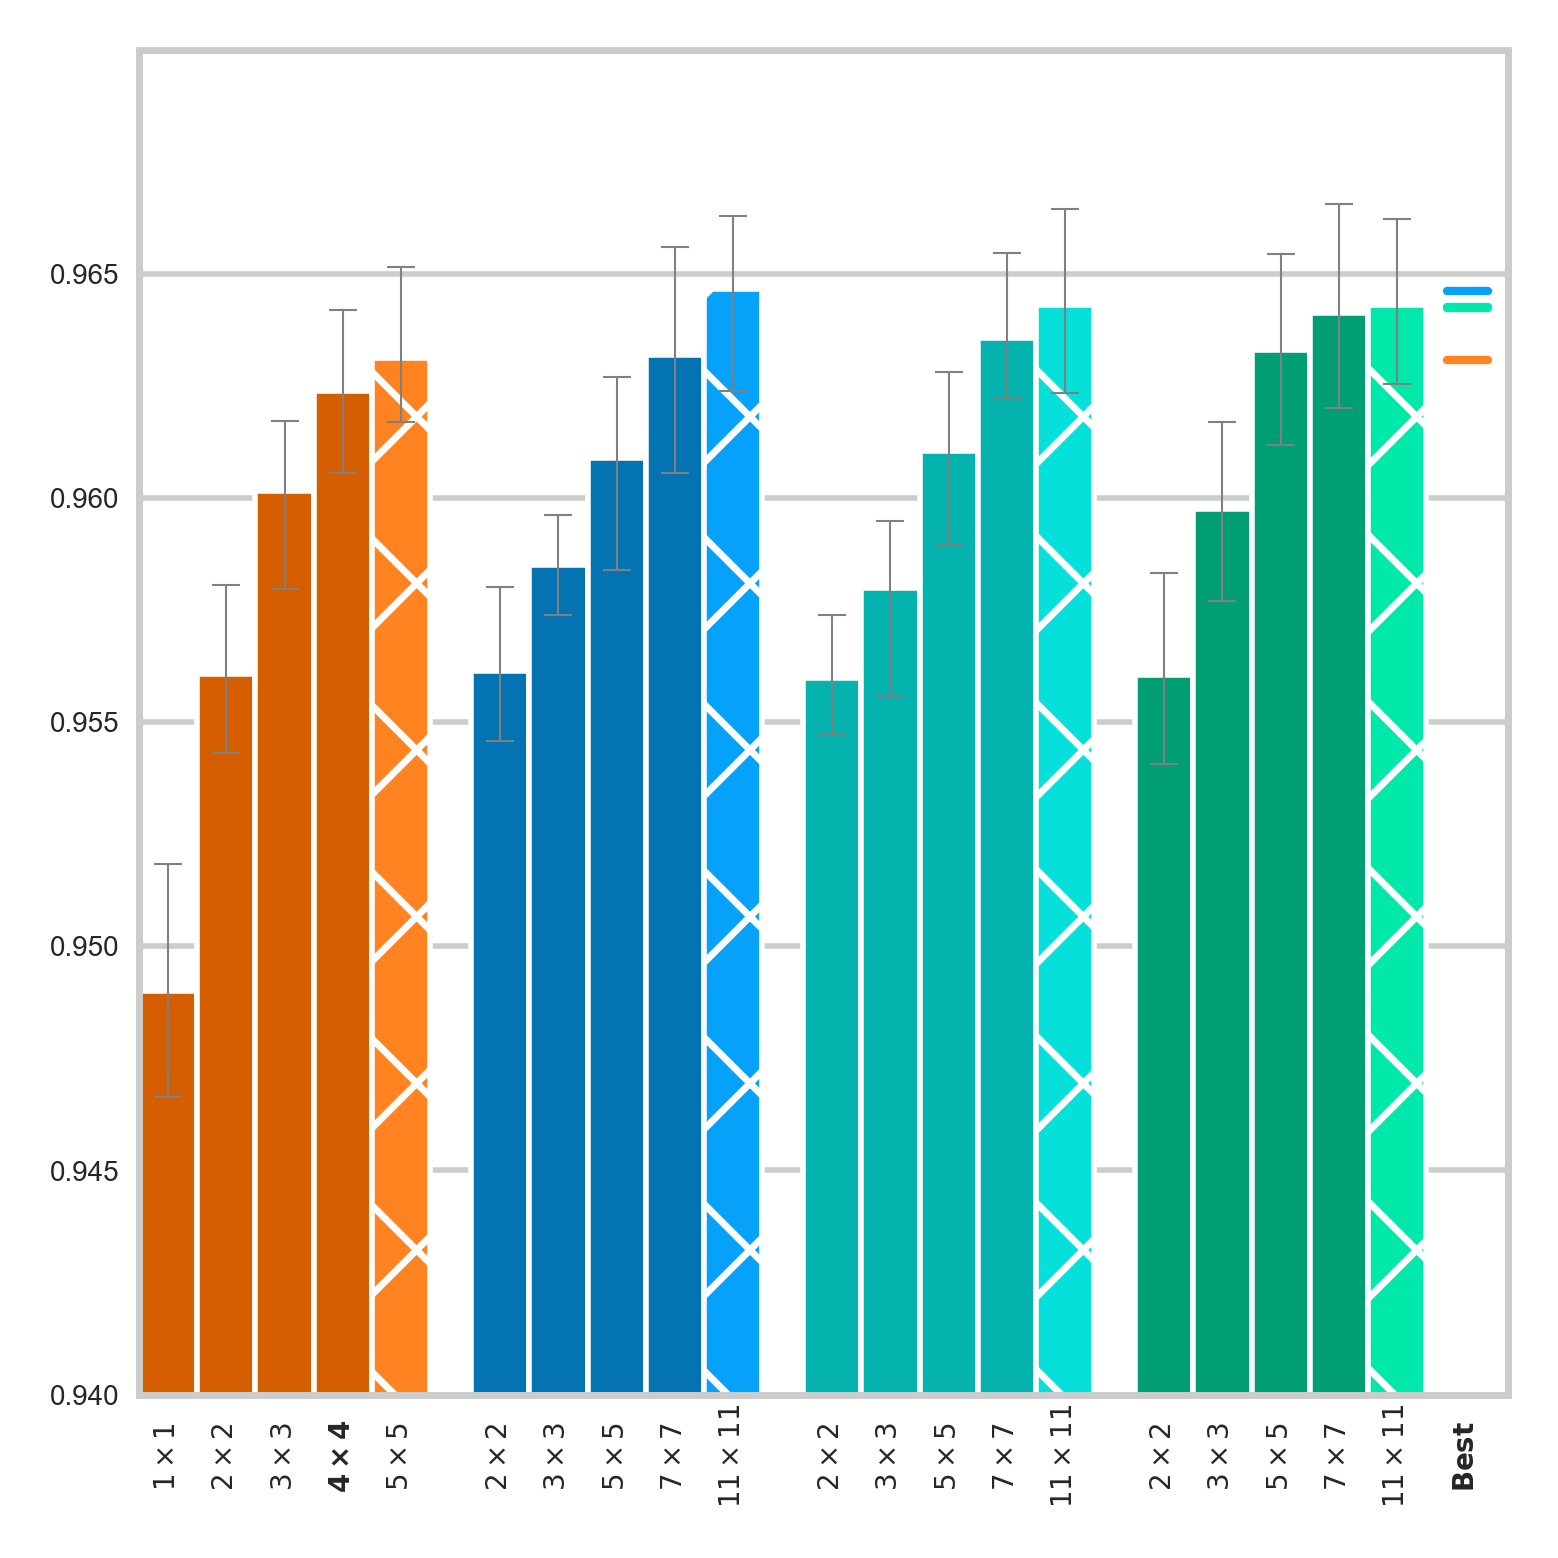

In [269]:
plot_results(
    plot_group_kernel_size,
    preprocess_data(pl.read_parquet("./.data/long_svhn.pq")),
    # save_path="./report/figures/results_fake.png",
)
plt.show()

In [ ]:
plot_results(
    plot_group_kernel_size,
    preprocess_data(fake_data, metric="train_times"),
    higher_is_better=False,
)
plt.title("Train run durations")
plt.ylim(0, 5)

In [236]:
fake_data_alt = pl.read_parquet("./.data/groups_k_mnist.pq").select(
    pl.col("iso-7-ss-gsize1").alias("iso-7-ss"),
    pl.col("iso-7-ss-gsize1-channeladd").alias("iso-7-ss-closing"),
    pl.col("iso-7-ss-gsize2").alias("iso-7-ss-grouped"),
    pl.col("iso-7-ss-gsize2-channeladd").alias("iso-7-ss-closing-grouped"),
    pl.col("aniso-7-ss-iso-spin-gsize1").alias("aniso-7-ss-iso-spin"),
    pl.col("aniso-7-ss-iso-spin-gsize1-channeladd").alias(
        "aniso-7-ss-iso-spin-closing"
    ),
    pl.col("aniso-7-ss-iso-spin-gsize2").alias("aniso-7-ss-iso-spin-grouped"),
    pl.col("aniso-7-ss-iso-spin-gsize2-channeladd").alias(
        "aniso-7-ss-iso-spin-closing-grouped"
    ),
    pl.col("aniso-7-skewed-spin-gsize1").alias("aniso-7-skewed-spin"),
    pl.col("aniso-7-skewed-spin-gsize1-channeladd").alias(
        "aniso-7-skewed-spin-closing"
    ),
    pl.col("aniso-7-skewed-spin-gsize2").alias("aniso-7-skewed-spin-grouped"),
    pl.col("aniso-7-skewed-spin-gsize2-channeladd").alias(
        "aniso-7-skewed-spin-closing-grouped"
    ),
)
fake_pre_alt = preprocess_data(fake_data_alt, metric="acc")
fake_pre_alt

kind,size,grouped,closing,low,mean,high
str,i64,bool,bool,f64,f64,f64
"""iso-ss""",7,false,false,0.954536,0.961025,0.96658
"""iso-ss""",7,false,true,0.953668,0.961058,0.967339
"""iso-ss""",7,true,false,0.938043,0.949932,0.959527
"""iso-ss""",7,true,true,0.914822,0.942027,0.955404
"""aniso-ss""",7,false,false,0.954536,0.961257,0.967556
…,…,…,…,…,…,…
"""aniso-ss""",7,true,true,0.924262,0.936484,0.958333
"""aniso-skewed""",7,false,false,0.953993,0.961788,0.96799
"""aniso-skewed""",7,false,true,0.954753,0.962018,0.967882


In [244]:
fake_pre_alt.filter(pl.col("kind").eq("iso-ss") & pl.col("size").eq(7))

kind,size,grouped,closing,low,mean,high
str,i64,bool,bool,f64,f64,f64
"""iso-ss""",7,false,false,0.954536,0.961025,0.96658
"""iso-ss""",7,false,true,0.953668,0.961058,0.967339
"""iso-ss""",7,true,false,0.938043,0.949932,0.959527
"""iso-ss""",7,true,true,0.914822,0.942027,0.955404


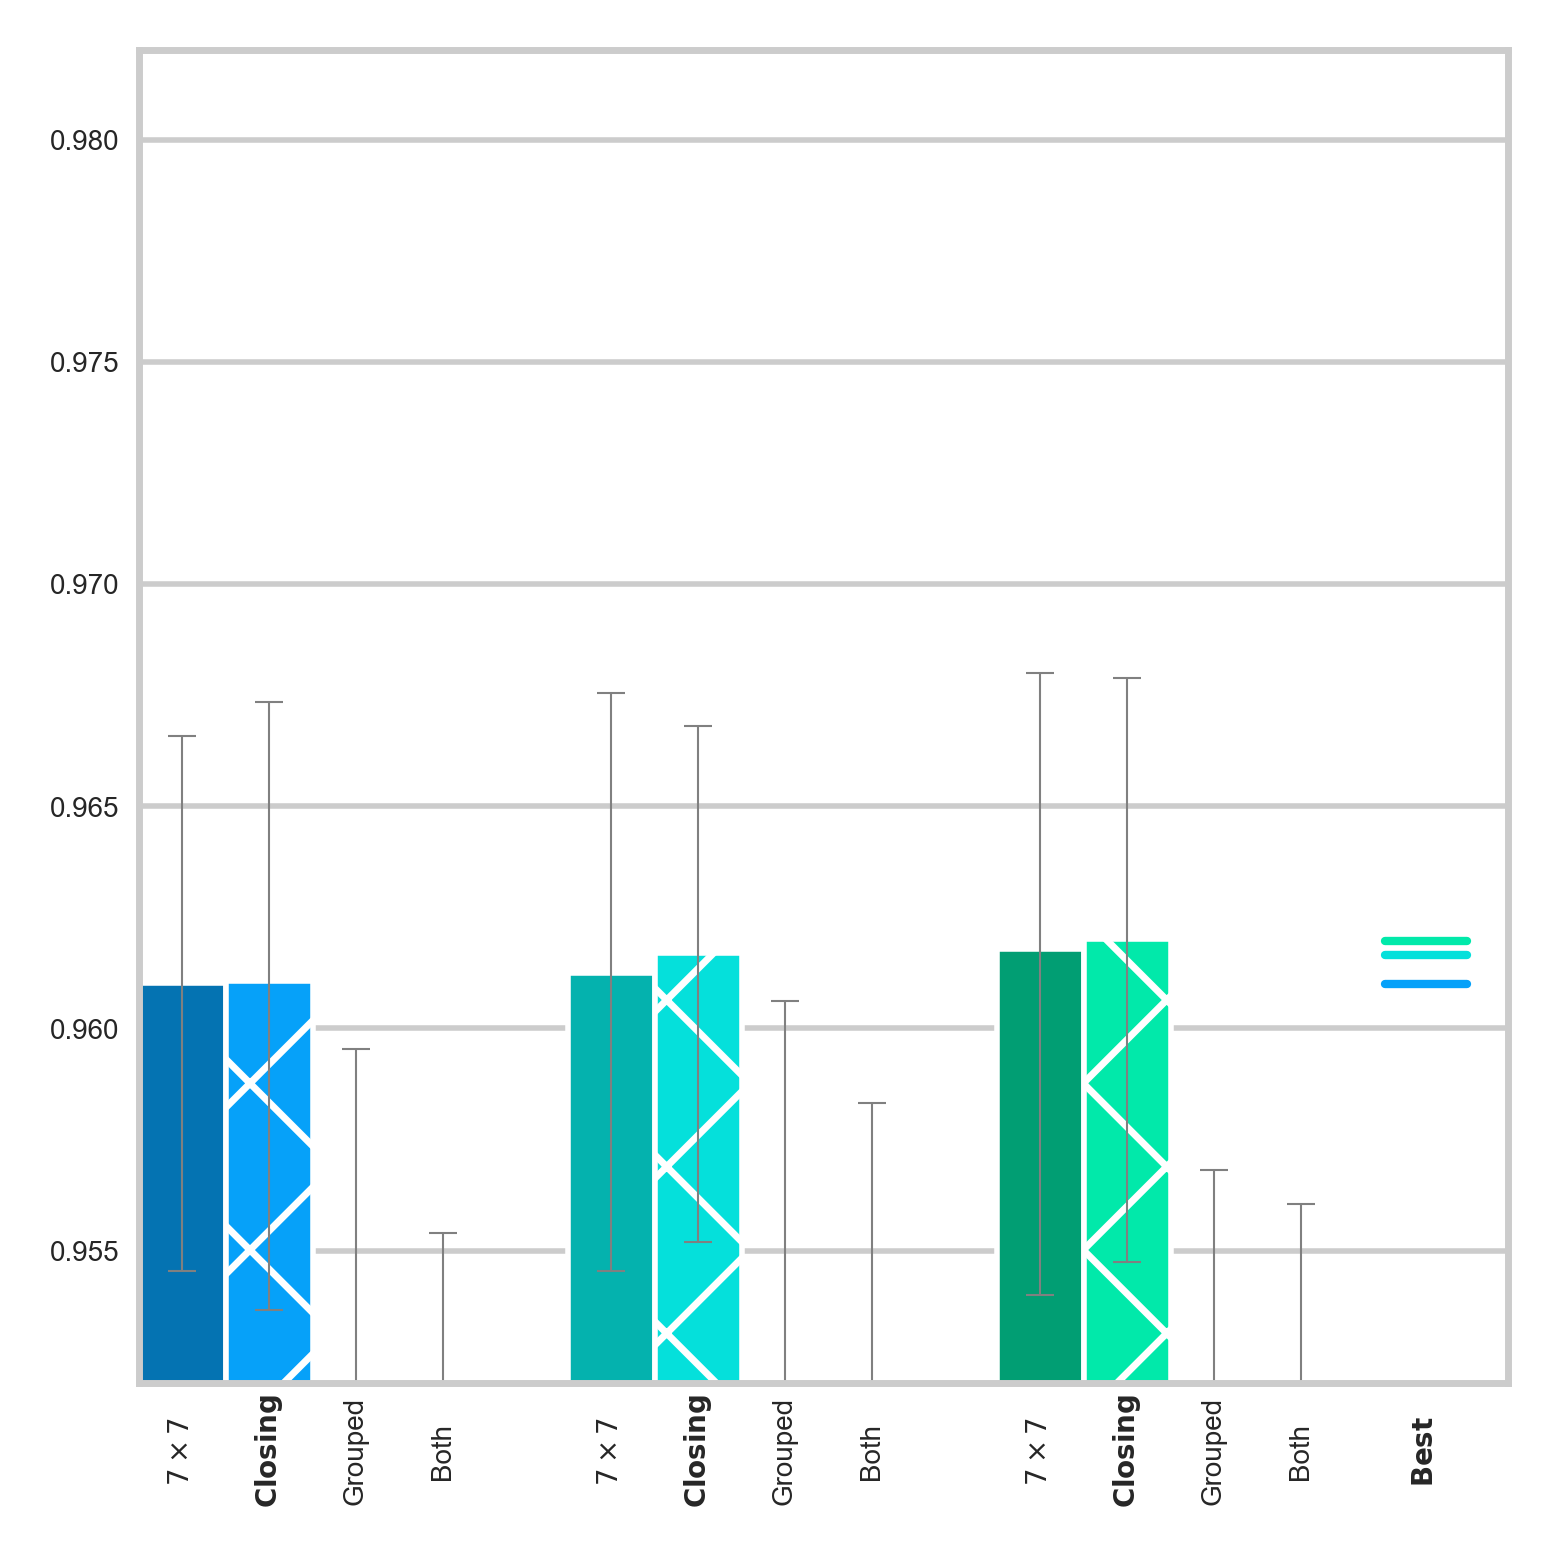

In [266]:
def plot_group_extra(
    ax: plt.Axes,
    tick_positions: list[float],
    tick_labels: list[str],
    group: pl.DataFrame,
    color: str,
    begin: float,
    width: float,
    highlight: str = None,
    higher_is_better: bool = True,
):
    best = (
        group.with_row_index()
        .top_k(1, by="mean", reverse=not higher_is_better)
        .item(0, column="index")
    )
    x = begin
    for i, (_kind, size, grouped, closing, low, mean, high) in enumerate(
        group.iter_rows()
    ):
        ax.bar(
            x,
            mean,
            width,
            align="edge",
            color=highlight if highlight and i == best else color,
            hatch="x" if highlight and i == best else "",
        )
        ax.errorbar(
            x + width / 2,
            mean,
            ((mean - low,), (high - mean,)),
            color="grey",
            capsize=2,
            linewidth=0.3,
            capthick=0.3,
        )
        tick_positions.append(x + width / 2)
        text = {
            (False, False): rf"{size}\times{size}",
            (False, True): r"Closing",
            (True, False): r"Grouped",
            (True, True): r"Both",
        }[(grouped, closing)]
        if i == best:
            label = rf"$\mathbf{{{text}}}$"
        else:
            label = rf"${text}$" if "\\" in text else text
        tick_labels.append(label)
        x += width


plot_results(
    plot_group_extra,
    fake_pre_alt,
    baseline=("iso-ss", 7),
    group_gap=0.06,
    x_tick_pad=5.0,
    save_path="./report/figures/results_fake_alt.png",
)
plt.show()